In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from argparse import Namespace
import matplotlib.pyplot as plt
import av2.rendering.vector as vector_plotting_utils
from shapely.geometry import Polygon

from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph

from av2.map.map_api import ArgoverseStaticMap
from av2.datasets.motion_forecasting import scenario_serialization

from av2.datasets.motion_forecasting.viz.scenario_visualization import (
    visualize_scenario
)
from av2.map.map_api import ArgoverseStaticMap
import os
import pickle
from tqdm import tqdm
import networkx as nx
os.getcwd()


from graph_creator.create_graph import get_scenario_data, plot_scene_at_timestep

In [2]:
from pathlib import Path
# repo_root = Path("/Users/marius/code/graph_coverage")
repo_root = Path.cwd()
while not (repo_root / ".git").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent
dataroot = repo_root / "argoverse_data" / "train"
print(repo_root)


/Users/marius/code/graph_coverage


In [3]:
scenario_folders = [f for f in dataroot.iterdir() if f.is_dir()]

# Print number of scenarios found
print(f"Found {len(scenario_folders)} scenarios")

Found 199908 scenarios


In [4]:
# @ Thomas run here for data creation for one scenario:

i = 1001
scenario = scenario_folders[i]
log_id = scenario.name
# check if file exists:
timestamp = 1.0
print(i, log_id)
scenario, map = get_scenario_data(dataroot, log_id)
G_map = MapGraph.create_from_argoverse_map(map)
actor_graph = ActorGraph.from_argoverse_scenario(
                                scenario, 
                                G_map, 
                                delta_timestep_s=1.0,
                                max_distance_lead_veh_m=50,
                                max_distance_opposite_forward_m=100,
                                max_distance_opposite_backward_m=10,
                                max_distance_neighbor_forward_m=50,
                                max_distance_neighbor_backward_m=20,
                                max_node_distance_leading=10,
                                max_node_distance_neighbor=6,
                                max_node_distance_opposite=6,
)

timestamps = list(actor_graph.actor_graphs.keys())
timestamp = timestamps[2]
actor_graph.actor_graphs[timestamp]
# check if graph is connected:
# nx.is_connected(actor_graph.actor_graphs[timestamp]) # not implemented for directed graphs... 
#dir(actor_graph)

actor_graph.actor_components[timestamp]

keys = list(actor_graph.actor_graphs.keys())
for  key in keys:
    actor_graph.actor_components[key] = [actor_graph.actor_components[key][i] for i in range(len(actor_graph.actor_components[key])) if actor_graph.actor_components[key][i].size() > 1]

for timestamp in timestamps:
    for component_idx in range(len(actor_graph.actor_components[timestamp])):
        # save_path = f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components/graph_{log_id}_{timestamp}_{component_idx}.pkl'
        save_path = f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{log_id}_{str(timestamp).replace(".", "_")}_{component_idx}.pkl'
        # with open(save_path, "wb") as file:
        #     pickle.dump(actor_graph.actor_components[timestamp][component_idx], file)

1001 00a26d3e-4d90-4ff9-87b9-d6e5903dc9ab


Trial 0: 000ace8b-a3d2-4228-bd87-91b66a9c5127
  Using first timestep: 1.0
  following_lead: 1 total edges
  leading_vehicle: 1 total edges
  neighbor_vehicle: 0 total edges
  opposite_vehicle: 6 total edges
  Criteria not met, continuing...
Trial 1: d25d1aaa-8bb2-4c6b-98a5-fa5aa2ddd2eb
  Using first timestep: 1.0
  following_lead: 22 total edges
  leading_vehicle: 22 total edges
  neighbor_vehicle: 0 total edges
  opposite_vehicle: 8 total edges
  Criteria not met, continuing...
Trial 2: 5758074f-be16-49da-8bb5-d43a0d8cd034
  Using first timestep: 1.0
  following_lead: 4 total edges
  leading_vehicle: 4 total edges
  neighbor_vehicle: 2 total edges
  opposite_vehicle: 4 total edges
  Criteria not met, continuing...
Trial 3: 9688c3e8-525c-4557-a60f-a64ad6f18b55
  Using first timestep: 1.0
  following_lead: 10 total edges
  leading_vehicle: 10 total edges
  neighbor_vehicle: 8 total edges
  opposite_vehicle: 0 total edges
  Criteria not met, continuing...
Trial 4: 7ad01855-0735-482d-8ee2

/Users/marius/code/graph_coverage/graph_creator/MapGraph.py:341: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=10)


PicklingError: Can't pickle <class 'graph_creator.ActorGraph.ActorGraph'>: it's not the same object as graph_creator.ActorGraph.ActorGraph

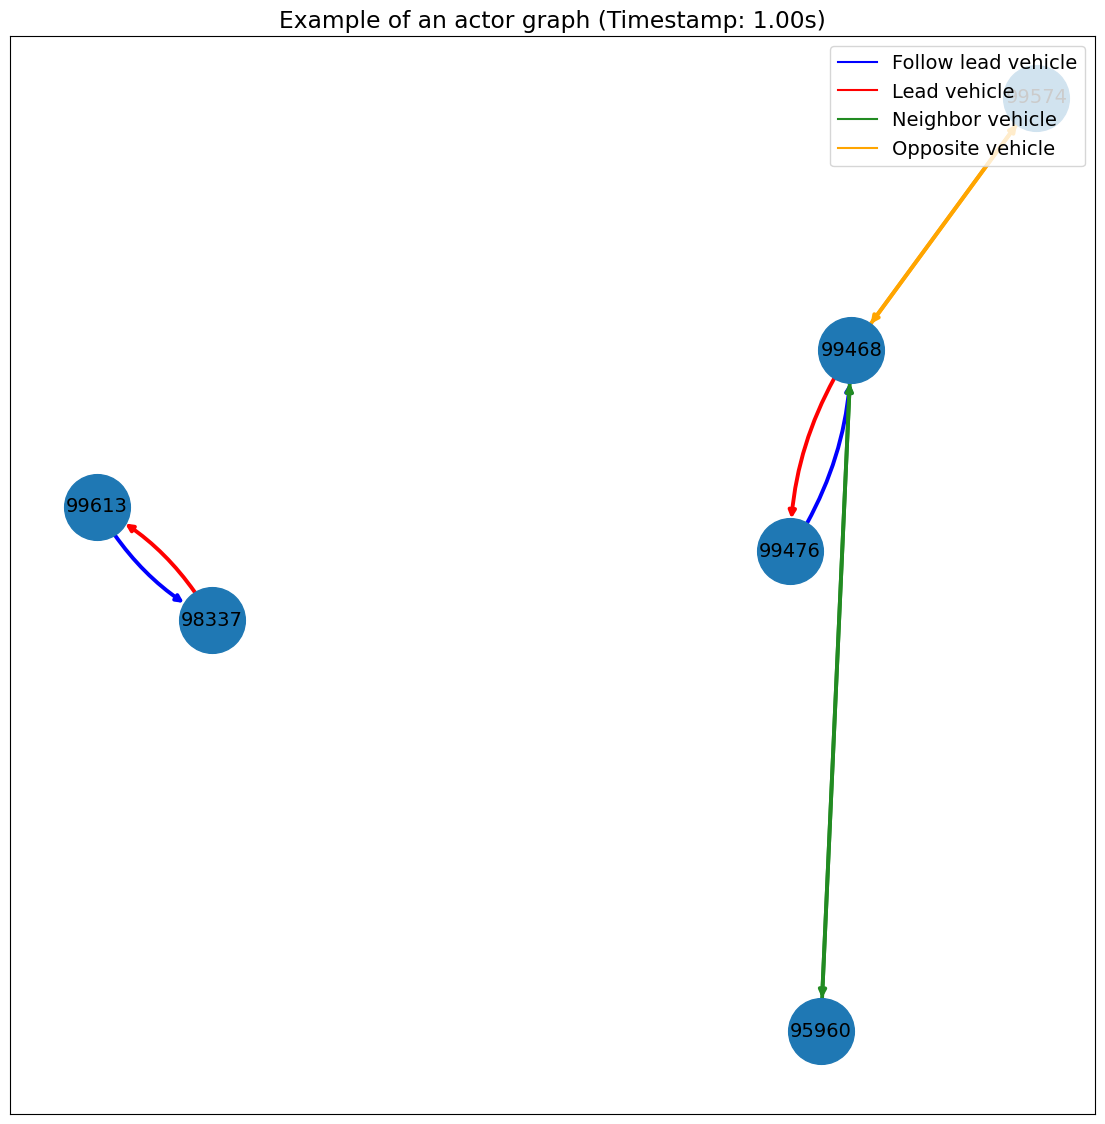

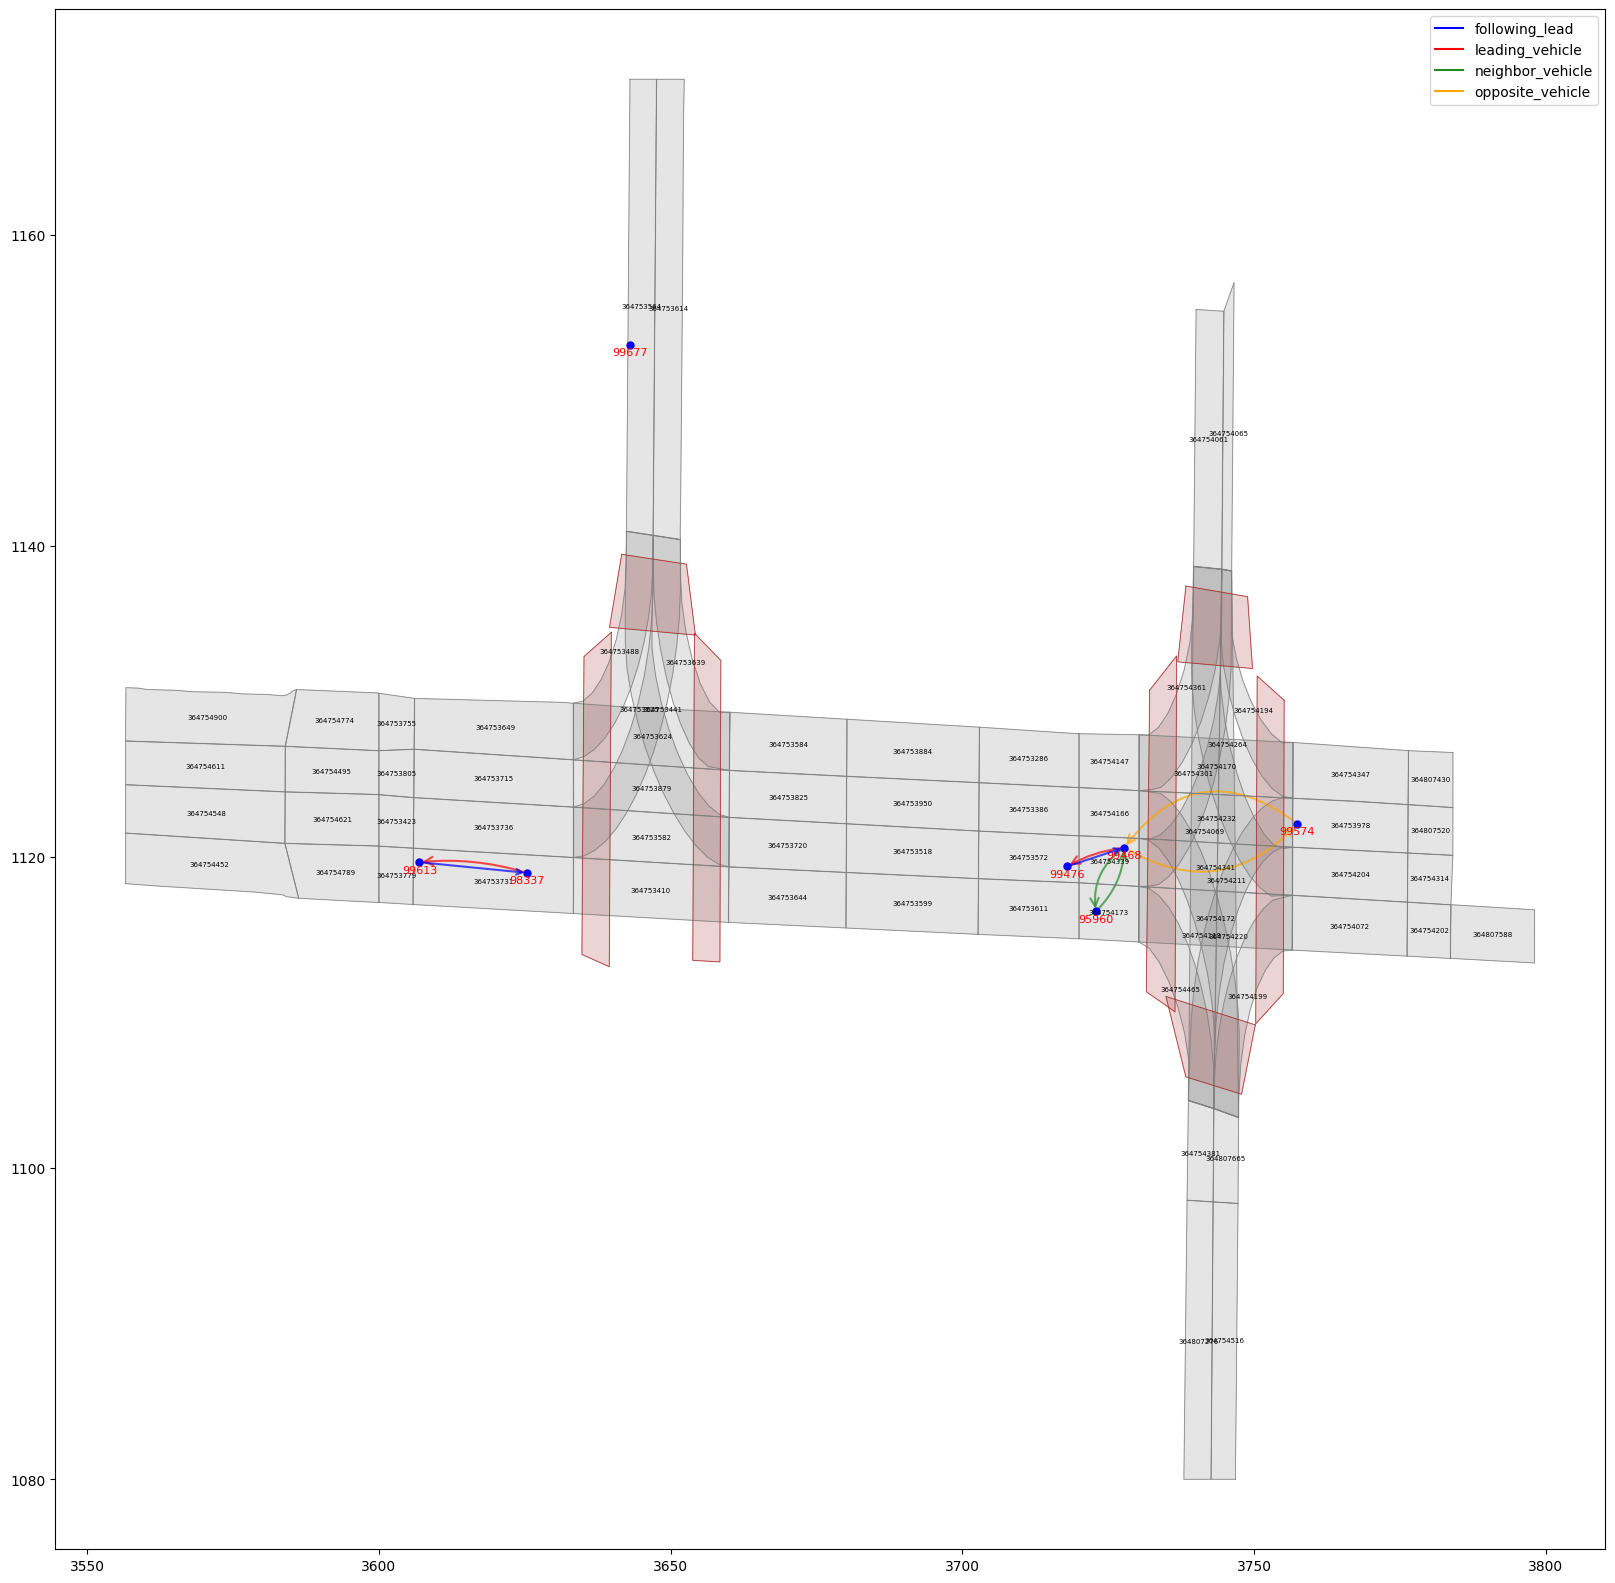

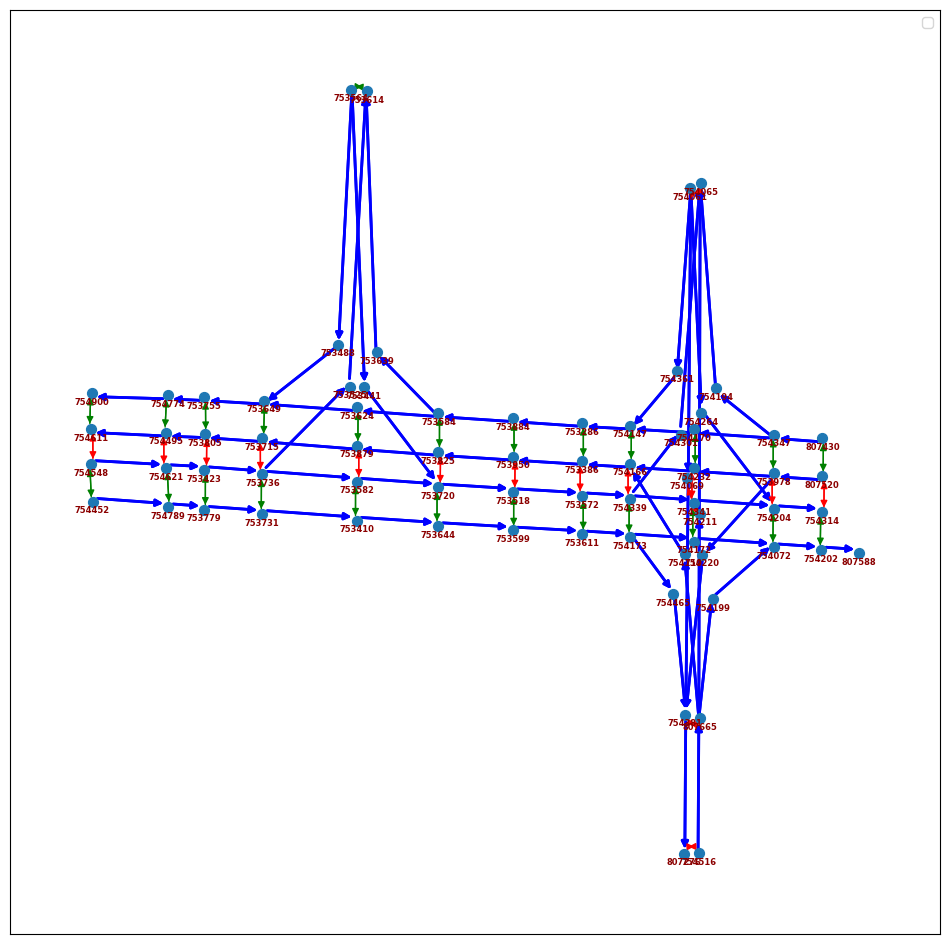

In [11]:
# @ Thomas run here for data creation - continue until finding 4 graphs matching criteria
actor_graphs = []
matching_graphs_found = 0
target_count = 4

# Create necessary directories
(repo_root / "plots").mkdir(parents=True, exist_ok=True)
(repo_root / "actor_graphs" / "argoverse").mkdir(parents=True, exist_ok=True)

for i, scenario in enumerate(scenario_folders):
    if matching_graphs_found >= target_count:
        print(f"\n✓ Found {target_count} matching graphs! Stopping search.")
        break
        
    log_id = scenario.name
    print(f"Trial {i}: {log_id}")
    
    scenario, map = get_scenario_data(dataroot, log_id)
    G_map = MapGraph.create_from_argoverse_map(map)
    actor_graph = ActorGraph.from_argoverse_scenario(
                                    scenario, 
                                    G_map, 
                                    delta_timestep_s=1.0,
                                    max_distance_lead_veh_m=50,
                                    max_distance_opposite_forward_m=100,
                                    max_distance_opposite_backward_m=10,
                                    max_distance_neighbor_forward_m=50,
                                    max_distance_neighbor_backward_m=20,
                                    max_node_distance_leading=10,
                                    max_node_distance_neighbor=6,
                                    max_node_distance_opposite=6,
    )
    
    # Get the first timestep (first available timestep)
    if not actor_graph.actor_graphs:
        print(f"  No timesteps found, skipping...")
        continue
    
    timestamps = sorted(actor_graph.actor_graphs.keys())
    timestamp = timestamps[0]  # Use first timestep
    print(f"  Using first timestep: {timestamp}")
        
    G_t = actor_graph.actor_graphs[timestamp]
    
    # Count edges by type
    edge_counts = {
        'following_lead': 0,
        'leading_vehicle': 0,
        'neighbor_vehicle': 0,
        'opposite_vehicle': 0
    }
    
    for u, v, data in G_t.edges(data=True):
        edge_type = data.get('edge_type', '')
        if edge_type in edge_counts:
            edge_counts[edge_type] += 1
    
    print(f"  following_lead: {edge_counts['following_lead']} total edges")
    print(f"  leading_vehicle: {edge_counts['leading_vehicle']} total edges")
    print(f"  neighbor_vehicle: {edge_counts['neighbor_vehicle']} total edges")
    print(f"  opposite_vehicle: {edge_counts['opposite_vehicle']} total edges")
    
    # Check if criteria are met:
    # - At most 2 leading vehicle relations (≤2)
    # - At most 2 following relations (≤2)
    # - At most 4 opposite relations (≤4)
    # - At most 4 neighbor relations (≤4)
    # - At least one of each relation type (≥1 for each)
    meets_criteria = (
        edge_counts['leading_vehicle'] <= 2 and
        edge_counts['following_lead'] <= 2 and
        edge_counts['opposite_vehicle'] <= 4 and
        edge_counts['neighbor_vehicle'] <= 4 and
        edge_counts['leading_vehicle'] >= 1 and
        edge_counts['following_lead'] >= 1 and
        edge_counts['opposite_vehicle'] >= 1 and
        edge_counts['neighbor_vehicle'] >= 1
    )
    
    if meets_criteria:
        matching_graphs_found += 1
        print(f"\n✓ Found matching graph #{matching_graphs_found} at trial {i}!")
        print(f"  Criteria met: leading≤2, following≤2, opposite≤4, neighbor≤4, all≥1")
        
        # Plot the graph
        actor_graph.visualize_actor_graph(t_idx=timestamp, comp_idx=0, save_path=(repo_root / "plots" / f"{log_id}_actor_graph.png"))
        plot_scene_at_timestep(scenario, map, timestamp, save_path=(repo_root / "plots" / f"{log_id}_scene_at_{timestamp}.png"), lane_label=True, actor_graph=actor_graph)
        G_map.visualize_graph(save_path=(repo_root / "plots" / f"{log_id}_map_graph.png"))
        
        # Save the graph
        with open(repo_root / "actor_graphs" / "argoverse" / f"{log_id}_map_graph.pkl", "wb") as f:
            pickle.dump(G_map, f)
        with open(repo_root / "actor_graphs" / "argoverse" / f"{log_id}_actor_graph.pkl", "wb") as f:
            pickle.dump(actor_graph, f)
        
        actor_graphs.append(actor_graph)
    else:
        print(f"  Criteria not met, continuing...")

if matching_graphs_found < target_count:
    print(f"\nOnly found {matching_graphs_found} matching graphs out of {target_count} requested.")

   

In [12]:
# Split the graphs into networkx data
argoverse_dir = repo_root / "actor_graphs" / "argoverse"
argoverse_nx_dir = repo_root / "actor_graphs" / "argoverse_nx"

# Create output directory if it doesn't exist
argoverse_nx_dir.mkdir(parents=True, exist_ok=True)

# Get all actor graph files
argoverse_files = list(argoverse_dir.glob("*_actor_graph.pkl"))
argoverse_scns = [f.stem.replace("_actor_graph", "") for f in argoverse_files if f.name.endswith("_actor_graph.pkl")]

print(f"Found {len(argoverse_scns)} actor graph files")
if argoverse_scns:
    print(f"First 3 scenarios: {argoverse_scns[:3]}")

for scn in tqdm(argoverse_scns):
    actor_graph_path = argoverse_dir / f"{scn}_actor_graph.pkl"
    if not actor_graph_path.exists():
        continue
        
    with open(actor_graph_path, "rb") as f:
        actor_graph = pickle.load(f)
    
    timestamps = list(actor_graph.actor_graphs.keys())
    for timestamp in timestamps:
        save_path = argoverse_nx_dir / f"graph_{scn}_{str(timestamp).replace('.', '_')}.pkl"
        with open(save_path, "wb") as file:
            pickle.dump(actor_graph.actor_graphs[timestamp], file)

print(f"\n✓ Saved {len(argoverse_scns)} scenarios with networkx graphs to {argoverse_nx_dir}")


Found 1000 actor graph files
First 3 scenarios: ['5a4714e1-0f95-4157-aaf5-70a869e0bcdc', 'f8fe5444-7128-43d6-80be-110d6a5f873d', '99449332-1eb4-4f0b-8416-408408300726']


 37%|███▋      | 373/1000 [00:10<00:18, 33.94it/s]


KeyboardInterrupt: 

In [ ]:
# actor_graphs = []
# import pickle

# for i, scenario in enumerate(scenario_folders):
#     if i >= 5:
#         break
# #if True: 
#     #log_id = "d25d1aaa-8bb2-4c6b-98a5-fa5aa2ddd2eb"
#     log_id = scenario.name
#     print(log_id)
#     timestamp = 1.0
#     scenario, map = get_scenario_data(dataroot, log_id)
#     G_map = MapGraph.create_from_argoverse_map(map)
#     actor_graph = ActorGraph.from_argoverse_scenario(
#                                     scenario, 
#                                     G_map, 
#                                     delta_timestep_s=1.0,
#                                     max_distance_lead_veh_m=50,
#                                     max_distance_opposite_forward_m=100,
#                                     max_distance_opposite_backward_m=10,
#                                     max_distance_neighbor_forward_m=50,
#                                     max_distance_neighbor_backward_m=20,
#                                     max_node_distance_leading=10,
#                                     max_node_distance_neighbor=6,
#                                     max_node_distance_opposite=6,
#     )
#     actor_graphs.append(actor_graph)
#     actor_graph.visualize_actor_graph(t_idx=timestamp, comp_idx=0,  save_path=(repo_root / "plots" / f"{log_id}_actor_graph.png"))
#     #visualize_scenario(scenario, map, save_path=(repo_root / f"{log_id}_video_.mp4") )
#     plot_scene_at_timestep(scenario, map, timestamp, save_path=(repo_root / "plots" / f"{log_id}_scene_at_{timestamp}.png"), lane_label=True, actor_graph=actor_graph)
#     G_map.visualize_graph(save_path=(repo_root / "plots" / f"{log_id}_map_graph.png"))
#     #with open(repo_root / "data" / f"{log_id}_map_graph.pkl", "wb") as f:
#     #    pickle.dump(G_map, f)
#     #with open(repo_root / "data" / f"{log_id}_actor_graph.pkl", "wb") as f:
#     #    pickle.dump(actor_graph, f)


In [ ]:
import pickle
# Save actor graphs and map data to pickle files
output_dir = repo_root / "data"
output_dir.mkdir(exist_ok=True)

# Save actor graphs
actor_graphs_file = output_dir / "actor_graph_argoverse.pkl"
with open(actor_graphs_file, "wb") as f:
    pickle.dump(actor_graphs, f)

# Save map data for each scenario
map_file = output_dir / f"map_argoverse.pkl"
with open(map_file, "wb") as f:
    pickle.dump(G_map, f)



In [ ]:
from subgraphs.SubgraphExtractor import SubgraphExtractor
import os

# Example usage of the SubgraphExtractor
def analyze_actor_graphs(actor_graphs, strategy='frequency', output_dir=None):
    """
    Analyze actor graphs to find common subgraphs using the specified strategy.
    
    Args:
        actor_graphs: List of ActorGraph objects
        strategy: Strategy for selecting subgraphs
        output_dir: Directory to save visualizations
    
    Returns:
        SubgraphExtractor instance
    """
    
    # Initialize extractor with specified strategy
    extractor = SubgraphExtractor(
        min_subgraph_size=3,
        max_subgraph_size=5, 
        # Custom matchers can be defined here if needed
    )
    
    # Extract subgraphs
    subgraph_library = extractor.extract_subgraphs(actor_graphs[:10])
    
    # Print properties
    extractor.print_subgraph_properties()
    
    # Visualize subgraphs
    if output_dir is not None:
        strategy_dir = os.path.join(output_dir, f"strategy_{strategy}")
        extractor.visualize_subgraphs(output_dir=strategy_dir)
    else:
        extractor.visualize_subgraphs()
    
    return extractor

# Create visualization output directory
output_dir = repo_root /  "plots" / "subgraph_analysis"
os.makedirs(output_dir, exist_ok=True)

# Analyze with different strategies
strategies = ['frequency', 'density', 'coverage', 'complexity', 'size']
extractors = {}

for strategy in strategies:
    extractors[strategy] = analyze_actor_graphs(actor_graphs, strategy, output_dir)

# Example of how to access the subgraphs for a specific actor graph and timestamp
print("\nExample of subgraph decomposition:")
print("=================================")
example_graph_idx = 0  # First graph in the list
example_timestamp = list(actor_graphs[example_graph_idx].actor_graphs.keys())[0]
print(f"Graph {example_graph_idx}, Timestamp {example_timestamp}:")

for sg_info in actor_graphs[example_graph_idx].actor_subgraphs[example_timestamp]:
    sg_id = sg_info['subgraph_id']
    nodes = sg_info['nodes']
    print(f"  Subgraph ID: {sg_id}, Nodes: {nodes}")
    # Additional information can be accessed from sg_info['node_mapping']